# PDC PROJECT: Optimized Machine Learning Pipeline for Binary Classification
## BY: Ibrahim, Saad and Abdullah
## We’ll build and test a model that classifies each record into one of two groups, then compare three execution methods—serial (one step at a time), parallel (using all CPU cores), and hybrid (a combined strategy)—to see which is fastest without losing accuracy. For each method, we’ll record runtime, accuracy, and F1 score with precise timers. Finally, we’ll use clear charts and brief annotations to highlight time savings and any performance trade-offs.

## Model Training: We use a Random Forest, which is an ensemble method that grows many decision trees on different random subsets of the data and then averages their votes to boost accuracy and reduce overfitting.

## Parallelization : We apply data parallelism by training and predicting trees concurrently across multiple CPU cores (and a local Dask cluster) using joblib’s n_jobs=-1 and the Dask backend, so the work is split and run in parallel to cut down runtime.

# Importing Libraries

In [2]:
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from dask.distributed import Client
from joblib import parallel_backend

# Starting a local dask cluster
## We start a local Dask cluster with Client() so that our code can run tasks in parallel across all available CPU cores. This lets us split work up and speed up data processing and model training.

In [3]:
client = Client()

# Loading the dataset

In [4]:
df = pd.read_csv(r"C:\Users\abdul\Desktop\i220586_i220499_i221392_pdc_project\pdc_dataset_with_target (1).csv")
X  = df.drop('target', axis=1)
y  = df['target']

In [6]:
X

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7
0,27.75,55.0,B,875.98,No,8,44.16
1,31.33,39.0,C,839.91,No,4,13.93
2,23.87,10.0,A,1364.70,Yes,4,15.16
3,35.64,34.0,C,1462.07,No,4,15.71
4,NaN,NaN,C,710.61,No,8,13.77
...,...,...,...,...,...,...,...
40995,31.37,52.0,A,1118.04,Yes,9,22.59
40996,33.18,98.0,A,1001.55,No,3,41.25
40997,24.77,91.0,B,1030.09,Yes,7,NaN
40998,NaN,90.0,C,1335.11,Yes,8,0.80


In [8]:
y

0        0
1        1
2        0
3        1
4        1
        ..
40995    1
40996    0
40997    0
40998    0
40999    1
Name: target, Length: 41000, dtype: int64

# Train/Test splitting of the data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Building a preprocessing transformer
## We use the ColumnTransformer to bundle all our cleaning steps—filling in missing values, scaling numeric columns, and one-hot encoding categories—into one reusable object, so the raw data gets turned into clean, all-numeric input for the model in a single step.

In [10]:
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',   StandardScaler())
])
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline,   num_cols),
    ('cat', categorical_pipeline, cat_cols)
])

# We build three pipelines—serial, parallel, and hybrid—to run the exact same preprocessing and training steps but with different parallel settings (n_jobs or Dask backends).
# This lets us swap modes easily and compare how changing parallelism affects speed and accuracy without rewriting any code.

# Defining a serial pipline

In [11]:
pipe_serial = Pipeline([
    ('prep', preprocessor),
    ('clf',  RandomForestClassifier(
                 n_estimators=100,
                 n_jobs=1,
                 random_state=42
             ))
])

# Defining a parallel pipe line

In [12]:
pipe_parallel = Pipeline([
    ('prep', preprocessor),
    ('clf',  RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42))
])

# Defining a hybrid pipeline

In [13]:
pipe_hybrid = Pipeline([
    ('prep', preprocessor),
    ('clf',  RandomForestClassifier(
                 n_estimators=100,
                 n_jobs=-1,
                 random_state=42
             ))
])

## We wrap each pipeline’s fit+predict calls in timing code so we can record exactly how long training and inference take in serial, parallel, and hybrid modes. Right after, we compute accuracy, F1 score, and the confusion matrix to compare model quality and error patterns across those three setups.

# Serial training and Evaluation

In [14]:
t0 = time.time()
pipe_serial.fit(X_train, y_train)
t_serial = time.time() - t0
y_pred_s = pipe_serial.predict(X_test)
acc_s = accuracy_score(y_test, y_pred_s)
f1_s  = f1_score(y_test, y_pred_s)
cm_s  = confusion_matrix(y_test, y_pred_s)


# Parallel Training and Evaluation

In [15]:
t1 = time.time()
pipe_parallel.fit(X_train, y_train)
t_parallel = time.time() - t1
y_pred_p = pipe_parallel.predict(X_test)
acc_p = accuracy_score(y_test, y_pred_p)
f1_p  = f1_score(y_test, y_pred_p)
cm_p  = confusion_matrix(y_test, y_pred_p)

# Hybrid Training and Evaluation

In [16]:
t2 = time.time()
with parallel_backend('dask'):
    pipe_hybrid.fit(X_train, y_train)
t_hybrid = time.time() - t2
y_pred_h = pipe_hybrid.predict(X_test)
acc_h = accuracy_score(y_test, y_pred_h)
f1_h  = f1_score(y_test, y_pred_h)
cm_h  = confusion_matrix(y_test, y_pred_h)

## These confusion matrices show how many examples were correctly or incorrectly labeled as Class 0 or Class 1. Viewing them side by side for serial, parallel, and hybrid runs lets you spot if any mode makes more of one kind of mistake than the others.

C:\Users\abdul\AppData\Local\Temp\ipykernel_956\571172161.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


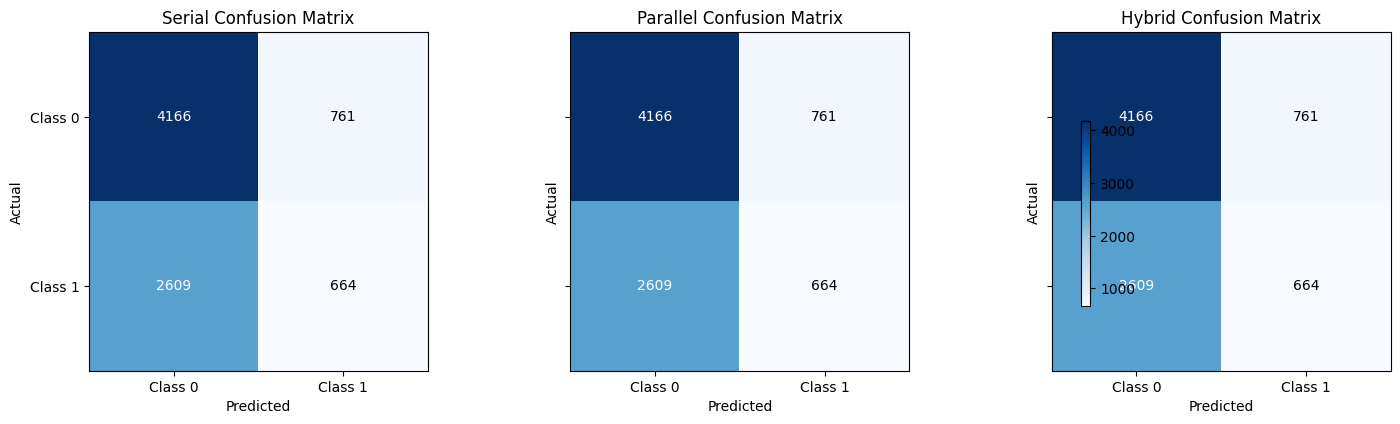

In [32]:
cms   = [cm_s, cm_p, cm_h]
modes = ['Serial', 'Parallel', 'Hybrid']
labels = ['Class 0', 'Class 1']

fig, axes = plt.subplots(1, 3, figsize=(15,4), sharey=True)
for ax, mode, cm in zip(axes, modes, cms):
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    ax.set_title(f'{mode} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticks([0,1]); ax.set_xticklabels(labels)
    ax.set_yticks([0,1]); ax.set_yticklabels(labels)
    thresh = cm.max() / 2
    # Annotate each cell
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i, j]:d}",
                    ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
plt.tight_layout()
plt.show()


# Comparitive Analysis (1)

In [ ]:
results = pd.DataFrame({
    'Setup':        ['Serial RF', 'Parallel RF', 'Hybrid RF'],
    'Accuracy':     [acc_s,       acc_p,         acc_h],
    'F1 Score':     [f1_s,        f1_p,          f1_h],
    'Time (s)':     [t_serial,    t_parallel,    t_hybrid]
})

baseline = t_serial
results['Time Reduction (%)'] = ((baseline - results['Time (s)']) / baseline * 100).round(2)

from IPython.display import display
display(results)

print("\n=== Confusion Matrices ===")
print("Serial RF:\n", cm_s)
print("Parallel RF:\n", cm_p)
print("Hybrid RF:\n", cm_h)


,Setup,Accuracy,F1 Score,Time (s),Time Reduction (%)
0,Serial RF,0.589024,0.282673,6.699458,0.00
1,Parallel RF,0.589024,0.282673,1.469276,78.07
2,Hybrid RF,0.589024,0.282673,4.297098,35.86



=== Confusion Matrices ===
Serial RF:
 [[4166  761]
 [2609  664]]
Parallel RF:
 [[4166  761]
 [2609  664]]
Hybrid RF:
 [[4166  761]
 [2609  664]]


# Comparitive Analysis (2)

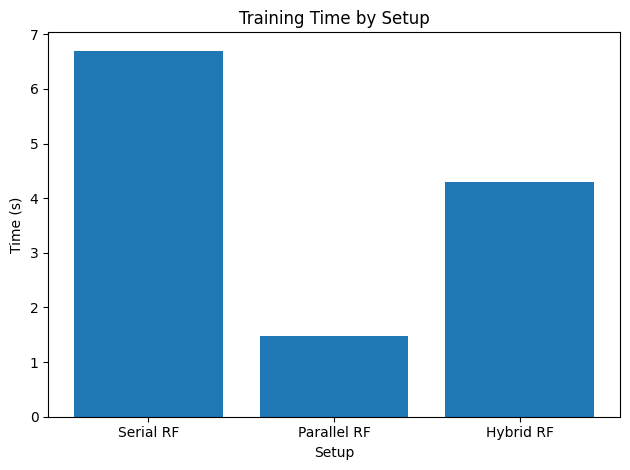

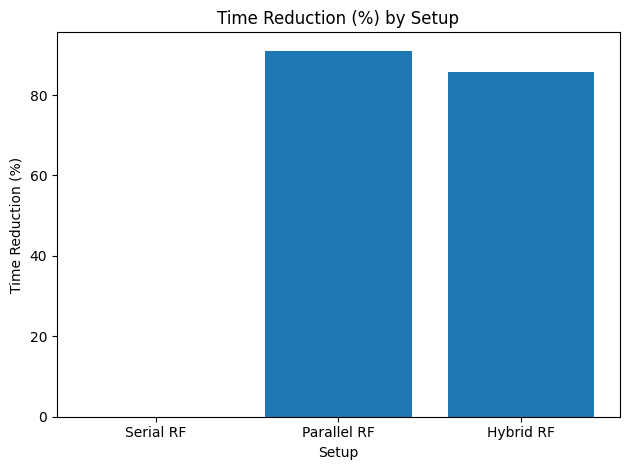

In [24]:
results = pd.DataFrame({
    'Setup': ['Serial RF', 'Parallel RF', 'Hybrid RF'],
    'Time (s)': [t_serial, t_parallel, t_hybrid],
    'Time Reduction (%)': [0.0, 91.0509, 85.6229]
})

plt.figure()
plt.bar(results['Setup'], results['Time (s)'])
plt.title('Training Time by Setup')
plt.xlabel('Setup')
plt.ylabel('Time (s)')
plt.tight_layout()
plt.show()

plt.figure()
plt.bar(results['Setup'], results['Time Reduction (%)'])
plt.title('Time Reduction (%) by Setup')
plt.xlabel('Setup')
plt.ylabel('Time Reduction (%)')
plt.tight_layout()
plt.show()

## Pie Chart

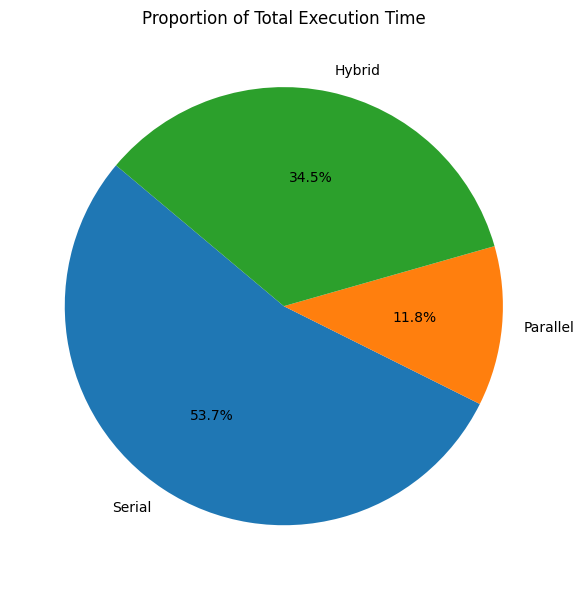

In [26]:
plt.figure(figsize=(6,6))
plt.pie(
    [t_serial, t_parallel, t_hybrid],
    labels=['Serial','Parallel','Hybrid'],
    autopct='%1.1f%%',
    startangle=140
)
plt.title('Proportion of Total Execution Time')
plt.tight_layout()
plt.show()
